In [38]:
import graphlab as gl
import graphlab.numpy
from datacleaner import autoclean
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Load some house sales data

In [42]:
# clean up the training data
my_data = pd.read_csv('../../data/train.csv', sep=',')
my_clean_data = autoclean(my_data)
my_data.to_csv('my_clean_train.csv', sep=',', index=False)
# clean up the test data
my_testdata = pd.read_csv('../../data/test.csv', sep=',')
my_clean_testdata = autoclean(my_testdata)
my_testdata.to_csv('my_clean_testdata.csv', sep=',', index=False)
predict_sales = gl.SFrame(my_testdata)

# Select only the columns which has correlations with SalePrice
It was found that the correlation > 0.3 performs the best and produce the best predictions

In [43]:
correlation = my_clean_data.corr()["SalePrice"]
print correlation

my_columns = np.sort(np.where(abs(correlation) > 0.3))
myFilteredData = my_clean_data.iloc[:, my_columns.tolist()[0]]
mynewcolumns = my_clean_data.iloc[:0, my_columns.tolist()[0]]
column_string = map(str, mynewcolumns)
print ''
print 'Top'
print np.count_nonzero(column_string)
print 'Highly Correlated Columns'
print column_string

features = myFilteredData.columns.tolist()

Id              -0.021917
MSSubClass      -0.084284
MSZoning        -0.166872
LotFrontage      0.334771
LotArea          0.263843
Street           0.041036
Alley           -0.027655
LotShape        -0.255580
LandContour      0.015453
Utilities       -0.014314
LotConfig       -0.067396
LandSlope        0.051152
Neighborhood     0.210851
Condition1       0.091155
Condition2       0.007513
BldgType        -0.085591
HouseStyle       0.180163
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
RoofStyle        0.222405
RoofMatl         0.132383
Exterior1st      0.103551
Exterior2nd      0.103766
MasVnrType       0.018216
MasVnrArea       0.472614
ExterQual       -0.636884
ExterCond        0.117303
Foundation       0.382479
                   ...   
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
KitchenQual     -0.589189
TotRmsAbvGrd     0.533723
Functional       0.115328
Fireplaces       0.466929
FireplaceQu      0.071177
GarageType  

# Instead of removing all outliers, we can replace the ourliers with NaN and then perform the auto-cleaning again to replace the NaN values with mean
This produces a better result than removing the rows completely if outliers are detected


In [44]:
my_dirtydata =  myFilteredData[np.abs(myFilteredData-myFilteredData.mean())<=(3*myFilteredData.std())]
myFilteredData_without_outliers = autoclean(my_dirtydata)
print myFilteredData_without_outliers

      LotFrontage  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0            65.0          7.0     2003.0          2003       196.0   
1            80.0          6.0     1976.0          1976         0.0   
2            68.0          7.0     2001.0          2002       162.0   
3            60.0          7.0     1915.0          1970         0.0   
4            84.0          8.0     2000.0          2000       350.0   
5            85.0          5.0     1993.0          1995         0.0   
6            75.0          8.0     2004.0          2005       186.0   
7            69.0          7.0     1973.0          1973       240.0   
8            51.0          7.0     1931.0          1950         0.0   
9            50.0          5.0     1939.0          1950         0.0   
10           70.0          5.0     1965.0          1965         0.0   
11           85.0          9.0     2005.0          2006       286.0   
12           69.0          5.0     1962.0          1962         0.0   
13    

In [45]:
#from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
#df = pd.DataFrame(myFilteredData, columns=column_string)
#myFilteredData_without_outliers = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
#print myFilteredData_without_outliers
#this is the filtered and outliers removed data
sales = gl.SFrame(myFilteredData_without_outliers)
# this is the original data without removing outliers and non-correlated columns
sales_ori = gl.SFrame(my_clean_data)

# Test from Nico

In [46]:
# Store all the feature labels of train_df into a list; remove the SalePrice.
features = myFilteredData_without_outliers.columns.tolist()
features.remove('SalePrice')

# Generate the training set. Set random_state to be able to replicate results.
# Our train data will contain 80% of train_df.
train = myFilteredData_without_outliers.sample(frac=0.8, random_state=1)

# Select anything not in the training set (20%) and put it in the validation set.
validation = myFilteredData_without_outliers.loc[~myFilteredData_without_outliers.index.isin(train.index)]

print "train (80%):"
print train.shape
print "validation (20%):"
print validation.shape

train (80%):
(1168, 26)
validation (20%):
(292, 26)


# Split 80% training data and 20% validation data

In [47]:
train_data,test_data = sales.random_split(.8,seed=0)
train_data_ori,test_data_ori = sales_ori.random_split(.8,seed=0)

print "train (80%):"
print train_data.shape
print "validation (20%):"
print test_data.shape

train (80%):
(1157, 26)
validation (20%):
(303, 26)


# Build the regression model
This first model uses only the Ground Living Area as the feature as it has the highest correlation score

In [48]:
GrLivArea_model = gl.linear_regression.create(train_data, target='SalePrice', features=['GrLivArea'])

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1108

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.001000     | 237529.342442      | 186629.342442        | 50031.853167  | 55242.501048    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# Evaluate the simple model (one feature)

This shows the mean SalePrice

In [142]:
print test_data['SalePrice'].mean()

176555.706271


"Max_error" means the outliers (USD500k is the outlier) and RMSE is the "Root Mean Square Error"

In [57]:
print GrLivArea_model.evaluate(test_data)

{'max_error': 223030.2809991993, 'rmse': 49844.513298478116}


In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

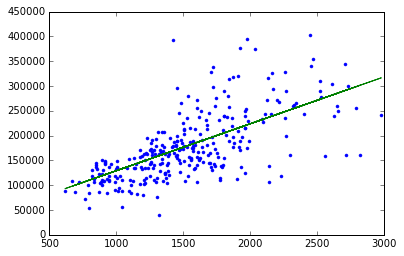

In [58]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], GrLivArea_model.predict(test_data), '-')

In [181]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,35092.5452584,4956.98509929
GrLivArea,None,94.8464691779,3.20041183547


The summary from table above is the value of y intercept is USD23490 and average price for GrLivArea is USD100 per sqf

# Create a new multi features model (Original - with 80 features)

In [17]:
my_features_model_ori = gl.linear_regression.create(train_data_ori,target='SalePrice')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1089

Number of features          : 80

Number of unpacked features : 80

Number of coefficients    : 81

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.016333     | 370204.123762      | 621368.240757        | 27564.742504  | 81235.490915    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# KNN Regressor

In [59]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(train[features], train['SalePrice'])

KNN_prediction = (neigh.predict(validation[features]))
print KNN_prediction
print(neigh.predict_proba(validation[features]))

print metrics.accuracy_score(validation.SalePrice, KNN_prediction)
                                    

[  73000.  280000.   55993.  108000.  147000.  109008.  108480.  143000.
  157000.   87000.  101000.  174000.  167000.  163500.  190000.  100000.
  107000.  145000.  172500.  163500.   82500.  217500.  130000.   97500.
  119000.  176000.   37900.  119000.  103000.  127000.  275000.  200000.
   82000.  172500.  271000.  186700.  174000.  129000.   34900.  176000.
  155000.  181000.  118000.  217000.   40000.  180000.  126175.  103000.
  184000.  125000.  171000.  135000.   87000.  137900.  290000.  250000.
   82500.   90000.   98600.  181000.  132500.  145000.   82500.  200000.
  187500.  113000.  165500.  125000.  113000.  106000.  161500.  121500.
  161500.   84500.   60000.  161500.  200000.   76000.  167000.  125500.
  108000.  139000.  169990.  212900.  173000.  167000.  147000.  161500.
  135000.  133000.   95000.  137000.   40000.  110500.  161500.  290000.
  115000.   82000.  235000.  240000.  133900.   80000.  133900.  248000.
  128500.  144000.  161500.   87000.  161500.  1615

# Random Forest Regressor

In [50]:
# Initialize the model.
# Note: The parameters given here are not really optimized yet. Apparantly, n_estimator
#       is the one we should pay the most attention to. For details see:
#       http://scikit-learn.org/stable/modules/ensemble.html#parameters

random_forest_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)

random_forest_model.fit(train[features], train['SalePrice'])

# Make predictions for our validation set.
predictions = random_forest_model.predict(validation[features])

# Compute the error.
print 'Mean Squared Error:', mean_squared_error(predictions, validation['SalePrice'])

Mean Squared Error: 832845204.164


# Create a new multi features model (After removing non-correlated columns)

In [31]:
my_features_model = gl.linear_regression.create(train_data,target='SalePrice')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1103

Number of features          : 25

Number of unpacked features : 25

Number of coefficients    : 26

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.006008     | 178402.805180      | 140871.676181        | 30776.831681  | 35441.371360    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [151]:
print column_string

['LotFrontage', 'Income2010', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


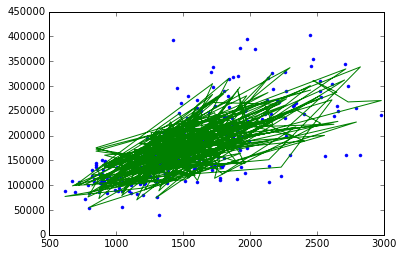

In [32]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], my_features_model.predict(test_data), '-')

In [33]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,33912.6355386,5027.15359691
GrLivArea,None,95.5865478942,3.24994888114


In [34]:
my_features_model.get('coefficients')

name,index,value,stderr
(intercept),None,-602263.927528,169920.913884
LotFrontage,None,155.149176355,59.7857924733
OverallQual,None,8595.15063457,1233.44632113
YearBuilt,None,143.143766671,66.8984161112
YearRemodAdd,None,295.674560948,66.465163027
MasVnrArea,None,29.9851144536,7.73541574856
ExterQual,None,-5715.3962179,2375.3144258
Foundation,None,2897.42047772,2049.52377245
BsmtQual,None,-3819.61831135,1525.95530115
BsmtFinSF1,None,15.8086588339,2.58933772309


# Result before removing outliers
{'max_error': 263715.68381302676, 'rmse': 53423.71497179019}
{'max_error': 200848.92346621933, 'rmse': 34190.02483489307}

# Result After replacing outliers with mean value
Maximum error reduced to 175653 {'max_error': 175653.45332768967, 'rmse': 33734.99971664569}

In [53]:
print 'Result with only one feature'
print GrLivArea_model.evaluate(test_data)
print ''
print 'Result before selecting correlated columns and replacing outliers with mean'
#result before selecting correlated columns and removing outliers
print my_features_model_ori.evaluate(test_data)
print ''
print 'Result after selecting correlated columns and replacing outliers with mean'
#result after selecting correlated columns
print my_features_model.evaluate(test_data)


Result with only one feature
{'max_error': 223030.2809991993, 'rmse': 49844.513298478116}

Result before selecting correlated columns and replacing outliers with mean
{'max_error': 204790.38266739127, 'rmse': 35023.23585566911}

Result after selecting correlated columns and replacing outliers with mean
{'max_error': 177026.3416139559, 'rmse': 33772.68373077335}


# Apply learned models to predict  prices of house

In [36]:
house1 = gl.SFrame(predict_sales)
X = house1.select_columns(['Id'])
# convert this to SArray
Y = X["Id"]

NameError: name 'predict_sales' is not defined

In [157]:
# Result from Random Forest Regressor

round_up = np.around(predictions, decimals=1, out=None)

sf = gl.SFrame({'Id':Y, 'SalePrice':round_up})
K =sf["Id","SalePrice"]
print K

+------+-----------+
|  Id  | SalePrice |
+------+-----------+
| 1461 |  123733.3 |
| 1462 |  149617.0 |
| 1463 |  185949.1 |
| 1464 |  184285.3 |
| 1465 |  203047.6 |
| 1466 |  182560.8 |
| 1467 |  166300.0 |
| 1468 |  173960.2 |
| 1469 |  189169.1 |
| 1470 |  128225.8 |
+------+-----------+
[1459 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [179]:
# Result from Linear Regression

my_results = my_features_model.predict(house1)
#print type(my_results)
round_up = np.around(my_results, decimals=1, out=None)

sf = gl.SFrame({'Id':Y, 'SalePrice':round_up})
Z =sf["Id","SalePrice"]
print Z

+------+-----------+
|  Id  | SalePrice |
+------+-----------+
| 1461 |  123914.9 |
| 1462 |  167098.6 |
| 1463 |  187493.0 |
| 1464 |  197470.3 |
| 1465 |  195233.4 |
| 1466 |  179987.3 |
| 1467 |  186546.1 |
| 1468 |  164796.3 |
| 1469 |  203158.3 |
| 1470 |  123365.6 |
+------+-----------+
[1459 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# Copy the result to a new csv file
The kaggel competition result shows 0.16879 score for Linear Regression
The kaggel competition result shows 0.17790 score for Random Forest Regressor

In [77]:
my_result = Z.save('predicted_houseprice.csv', format='csv')

In [133]:
#my_result = K.save('predicted_houseprice.csv', format='csv')